In [1]:
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn import model_selection

In [2]:
plasticizers = pd.read_excel('database/plasticizer_data_v4(rdkit_high_var).xls')
small_mols = pd.read_pickle('database/gdb17_5mil.pkl')

In [3]:
plasticizers = plasticizers[plasticizers.columns[1:]]

In [4]:
rdkit_cols = plasticizers.columns[5:]
small_mols = small_mols[rdkit_cols]

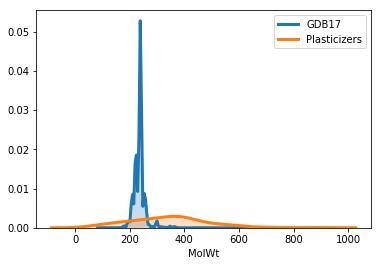

In [5]:
prop = 'MolWt'
sns.distplot(small_mols[prop], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label='GDB17')
sns.distplot(plasticizers[prop], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label='Plasticizers')
plt.show()

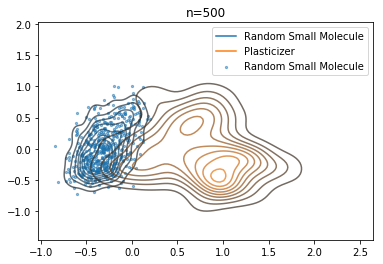

In [6]:
n=500
rdkit_cols_no_mw = list(set(rdkit_cols) - set(['MolWt']))
pca_data = plasticizers[rdkit_cols].to_numpy()
gdb_data = small_mols[rdkit_cols].sample(n=n).to_numpy()
joint_data = np.concatenate([pca_data, gdb_data], axis=0)

scaler = MinMaxScaler()
joint_data = scaler.fit_transform(joint_data)

joint_pca = PCA(n_components=2)
joint_pca.fit(joint_data)
joint_ics = joint_pca.transform(joint_data)

sns.kdeplot(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.7)
sns.kdeplot(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.7)
plt.scatter(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.5, s=5)
plt.legend(loc='best')
plt.title('n={}'.format(n))
plt.show()

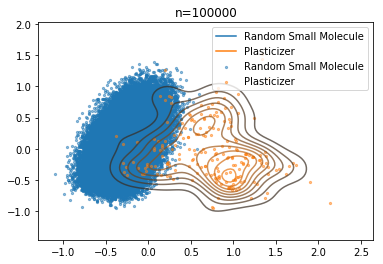

In [7]:
n=100000
gdb_test_sample = small_mols[rdkit_cols].sample(n=n).to_numpy()

gdb_test_sample = scaler.transform(gdb_test_sample)
test_ics = joint_pca.transform(gdb_test_sample)

sns.kdeplot(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.0)
sns.kdeplot(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.7)
plt.scatter(test_ics[:,0], test_ics[:,1], label='Random Small Molecule', alpha=0.5, s=5)
plt.scatter(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.5, s=5)
plt.legend(loc='best')
plt.title('n={}'.format(n))
plt.show()

# Investigating the Kernel Density Estimation as Plasticizer-Likelihood Function

In [8]:
def calc_kde(xis, lo, hi, h=0.17):
    kde = []
    xs = np.linspace(lo, hi, 101)
    for x in xs:
        kde_sum = 0
        for xi in xis:
            x_prime = (x - xi) / h
            kde_sum += 1 / (1 * math.sqrt(2*math.pi))*math.exp(-(1/2)*((x_prime - 0) / 1)**2)
        kde_sum /= len(xis)*h
        kde.append(kde_sum)
    return kde, xs

def get_kde_value(v, kde, xs):
    for i, x in enumerate(xs):
        if v < x:
            idx = i
            break
    val = kde[i]
    return val

def eval_acc(vs, boundary):
    hits = 0
    for v in vs:
        if v > boundary:
            hits += 1
        else:
            pass
    acc = hits / len(vs)
    return acc

def calc_2D_kde(x_vec, x_range, y_range, gridsize=101):
    # Using Scott's rule of thumb
    d = 2
    std_i = np.std(x_vec[:,0])
    std_j = np.std(x_vec[:,1])
    n = x_vec.shape[0]
    H_i = (n**(-1 / (d + 4))*std_i)**2
    H_j = (n**(-1 / (d + 4))*std_j)**2
    H = np.array([[H_i, 0], [0, H_j]])
    
    xs = np.linspace(x_range[0], x_range[1], gridsize)
    ys = np.linspace(y_range[0], y_range[1], gridsize)
    kde = np.zeros((gridsize, gridsize))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            kde_sum = 0
            for k in range(x_vec.shape[0]):
                xi = x_vec[k,:]
                x_prime = np.array([x, y]) - xi
                val = (2*math.pi)**(-d/2)*(np.linalg.det(H))**(-1/2)*math.exp(-(1/2)*x_prime.T@np.linalg.inv(H)@x_prime)
                kde_sum += val
            kde_sum /= n
            kde[i,j] = kde_sum
    return kde.T, xs, ys

def get_2D_kde_value(v, kde, xs, ys):
    idxs = []
    for i, x in enumerate(xs):
        if v[0] < x:
            idxs.append(i)
            break
    for j, y in enumerate(ys):
        if v[1] < y:
            idxs.append(j)
            break
    val = kde.T[idxs[0], idxs[1]]
    return val

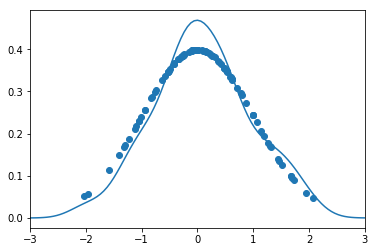

In [9]:
#Understanding KDE on Normal Distribution
mu = 0
sigma = 1
n = 100
xis = np.random.normal(mu, sigma, n)
ys = []
for xi in xis:
    y = 1 / (sigma * math.sqrt(2*math.pi))*math.exp(-(1/2)*((xi - mu) / sigma)**2)
    ys.append(y)

kde, xs = calc_kde(xis, -3, 3, h=0.3)
plt.plot(xs, kde)
plt.scatter(xis, ys)
plt.xlim([-3,3])
plt.show()
    


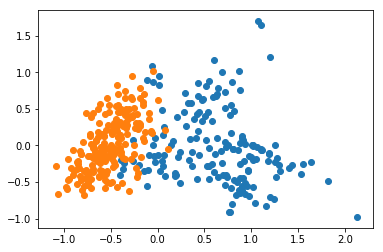

In [13]:
## PCA
X = plasticizers[rdkit_cols].to_numpy()
rand_idxs = np.random.choice(np.arange(len(X)), size=len(X), replace=False)
train_idxs = rand_idxs[:164]
test_idxs = rand_idxs[164:]
X_train = X[train_idxs,:]
X_test = X[test_idxs,:]

y = small_mols[rdkit_cols].sample(n=10000).to_numpy()
rand_idxs = np.random.choice(np.arange(len(y)), size=len(y), replace=False)
pca_idxs = rand_idxs[:200]
clf_idxs = rand_idxs[200:500]
test_idxs = rand_idxs[500:]
y_pca = y[pca_idxs,:]
y_clf = y[clf_idxs,:]
y_test = y[test_idxs,:]

joint_data = np.concatenate([X_train, y_pca], axis=0)

scaler = MinMaxScaler()
joint_data = scaler.fit_transform(joint_data)

joint_pca = PCA(n_components=2)
joint_pca.fit(joint_data)
joint_ics = joint_pca.transform(joint_data)
X_ics = joint_ics[:164,:]
y_ics = joint_ics[164:,:]

plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()

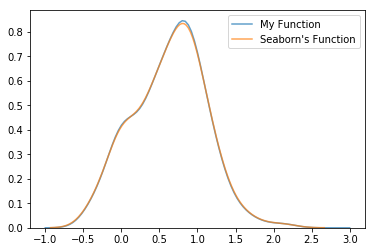

In [14]:
#Building 1D KDE for 1st PCA Component
xis = X_ics[:204,0]
kde, xs = calc_kde(xis, -1, 3)

plt.plot(xs, kde, label='My Function', alpha=0.7)
sns.kdeplot(xis, label='Seaborn\'s Function', alpha=0.7)
plt.show()

In [15]:
#Building 2D KDE for 1st 2 PCA Components
x_vec = X_ics[:204,:2]
kde, xs, ys = calc_2D_kde(x_vec, [-0.5, 2.5], [-1.5, 2.0], gridsize=101)

In [91]:
test_small_mols_db = small_mols[rdkit_cols].sample(n=10000).to_numpy()

test_small_mols = scaler.transform(test_small_mols_db)

test_ics = joint_pca.transform(test_small_mols)

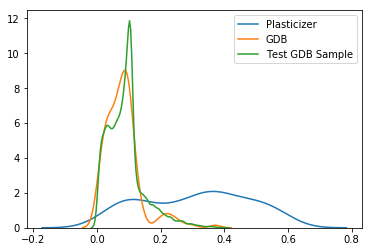

In [92]:
train_small_mols = joint_ics[204:,:2]
test_small_mols = test_ics[:,:2]
train_plast = joint_ics[:204,:2]
train_plast_lls = []
train_small_mol_lls = []
test_small_mol_lls = []
for i in range(train_plast.shape[0]):
    ll = get_kde_value(train_plast[i,:], kde, xs, ys)
    train_plast_lls.append(ll)
for i in range(train_small_mols.shape[0]):
    ll = get_kde_value(train_small_mols[i,:], kde, xs, ys)
    train_small_mol_lls.append(ll)
for i in range(test_small_mols.shape[0]):
    ll = get_kde_value(test_small_mols[i,:], kde, xs, ys)
    test_small_mol_lls.append(ll)
sns.distplot(train_plast_lls, hist=False, kde=True, label='Plasticizer')
sns.distplot(train_small_mol_lls, hist=False, kde=True, label='GDB')
sns.distplot(test_small_mol_lls, hist=False, kde=True, label='Test GDB Sample')
plt.show()

### Validation

# One-Class Classification

In [21]:
y_clf_ics = joint_pca.transform(scaler.transform(y_clf))
y_test_ics = joint_pca.transform(scaler.transform(y_test))
X_test_ics = joint_pca.transform(scaler.transform(X_test))

In [22]:
def in_class_acc(X, clf):
    X_predict = clf.predict(X)
    in_class_acc = 0
    for predict in X_predict:
        if predict == 1:
            in_class_acc += 1
    in_class_acc /= len(X_predict)
    return in_class_acc

/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


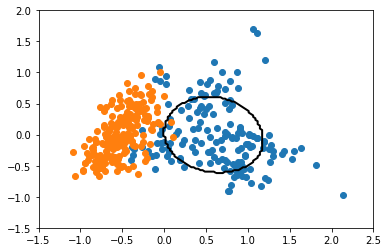

Train Acc - 50.0%   Test Acc - 45.0%


In [31]:
## OneClassSVM

clf = OneClassSVM()
clf.fit(X_ics)
train_acc = in_class_acc(X_ics, clf)
test_acc = in_class_acc(X_test_ics, clf)

xx, yy = np.meshgrid(np.linspace(-1.5,2.5,150),
                     np.linspace(-1.5,2.0,150))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()
print('Train Acc - {}%   Test Acc - {}%'.format(round(train_acc*100, 2), round(test_acc*100, 2)))

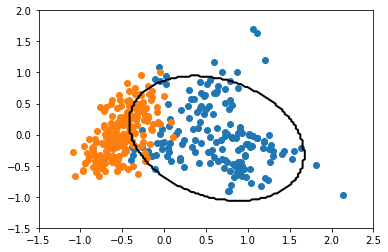

Train Acc - 89.63%   Test Acc - 87.5%


In [34]:
## Robust Covariance

clf = EllipticEnvelope(contamination=0.1)
clf.fit(X_ics)
train_acc = in_class_acc(X_ics, clf)
test_acc = in_class_acc(X_test_ics, clf)

xx, yy = np.meshgrid(np.linspace(-1.5,2.5,150),
                     np.linspace(-1.5,2.0,150))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()
print('Train Acc - {}%   Test Acc - {}%'.format(round(train_acc*100, 2), round(test_acc*100, 2)))

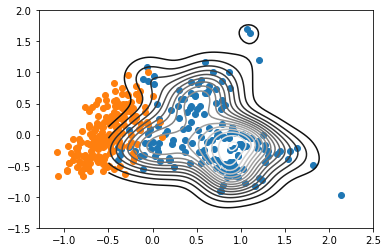

In [16]:
## KDE

plt.contour(xs, ys, kde, levels=15, cmap='gray')
plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()

In [42]:
all_plasts = plasticizers[rdkit_cols].to_numpy()
all_ics = joint_pca.transform(scaler.transform(all_plasts))

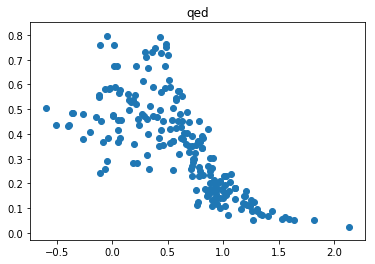

In [78]:
## Correlations b/w PCA and Descriptors

corrs = []
for i in range(all_plasts.shape[1]):
    data1 = all_plasts[:,i]
    data2 = all_ics[:,0]
    coeff = abs(np.corrcoef(data1, data2)[0][1])
    corrs.append(coeff)
    
corrs, cols = zip(*reversed(sorted(zip(corrs, rdkit_cols))))

col_id = 6
plt.scatter(all_ics[:,0], plasticizers[cols[col_id]])
plt.title(cols[col_id])
plt.show()

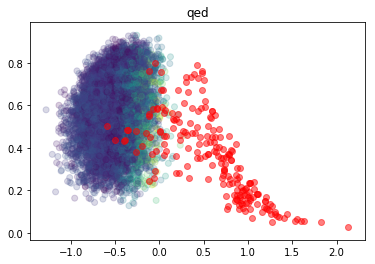

In [142]:
## Correlations b/w plasticizer likelihood and Descriptors

plast_corrs = []
for i in range(all_plasts.shape[1]):
    data1 = all_plasts[:,i]
    data2 = train_plast_lls
    coeff = abs(np.corrcoef(data1, data2)[0][1])
    plast_corrs.append(coeff)

# plast_corrs, plast_cols = zip(*reversed(sorted(zip(plast_corrs, rdkit_cols))))

test_corrs = []
for i in range(test_small_mols_db.shape[1]):
    data1 = test_small_mols_db[:,i]
    data2 = test_small_mol_lls
    coeff = abs(np.corrcoef(data1, data2)[0][1])
    test_corrs.append(coeff)

# test_corrs, test_cols = zip(*reversed(sorted(zip(test_corrs, rdkit_cols))))

col_id = 3
plt.scatter(test_ics[:,0], test_small_mols_db[:,col_id], c=test_small_mol_lls, alpha=0.2)
plt.scatter(all_ics[:,0], all_plasts[:,col_id], alpha=0.5, c='red')
plt.title(rdkit_cols[col_id])
plt.show()

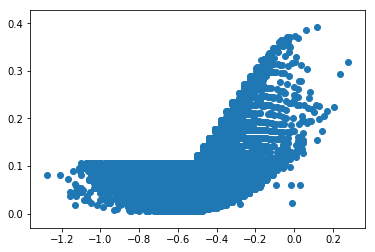

In [145]:
plt.scatter(test_ics[:,0], test_small_mol_lls)
plt.show()